In [1]:
from re import X
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class moving_avg(nn.Module):
    """
    Moving average block to highlight the trend of time series
    """
    def __init__(self, kernel_size, stride):
        super(moving_avg, self).__init__()
        self.kernel_size = kernel_size
        self.avg = nn.AvgPool1d(kernel_size=kernel_size, stride=stride, padding=0)

    def forward(self, x):
        # padding on the both ends of time series
        front = x[:, 0:1, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        end = x[:, -1:, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        x = torch.cat([front, x, end], dim=1)
        x = self.avg(x.permute(0, 2, 1))
        x = x.permute(0, 2, 1)
        return x


class series_decomp(nn.Module):
    """
    Series decomposition block
    """
    def __init__(self, kernel_size):
        super(series_decomp, self).__init__()
        self.moving_avg = moving_avg(kernel_size, stride=1)

    def forward(self, x):
        moving_mean = self.moving_avg(x)
        res = x - moving_mean
        return res, moving_mean

class Model(nn.Module):
    """
    DLinear
    """
    def __init__(self, configs):
        super(Model, self).__init__()
        self.seq_len = configs.seq_len
        self.pred_len = configs.pred_len

        # Decompsition Kernel Size
        kernel_size = 25
        self.decompsition = series_decomp(kernel_size)
        self.individual = configs.individual
        self.channels = configs.enc_in

        if self.individual:
            self.Linear_Seasonal = nn.ModuleList()
            self.Linear_Trend = nn.ModuleList()
            self.Linear_Decoder = nn.ModuleList()
            for i in range(self.channels):
                self.Linear_Seasonal.append(nn.Linear(self.seq_len,self.pred_len))
                self.Linear_Seasonal[i].weight = nn.Parameter((1/self.seq_len)*torch.ones([self.pred_len,self.seq_len]))
                self.Linear_Trend.append(nn.Linear(self.seq_len,self.pred_len))
                self.Linear_Trend[i].weight = nn.Parameter((1/self.seq_len)*torch.ones([self.pred_len,self.seq_len]))
                self.Linear_Decoder.append(nn.Linear(self.seq_len,self.pred_len))
        else:
            self.Linear_Seasonal = nn.Linear(self.seq_len,self.pred_len)
            self.Linear_Trend = nn.Linear(self.seq_len,self.pred_len)
            self.Linear_Decoder = nn.Linear(self.seq_len,self.pred_len)
            self.Linear_Seasonal.weight = nn.Parameter((1/self.seq_len)*torch.ones([self.pred_len,self.seq_len]))
            self.Linear_Trend.weight = nn.Parameter((1/self.seq_len)*torch.ones([self.pred_len,self.seq_len]))

    def forward(self, x):
        # x: [Batch, Input length, Channel]
        seasonal_init, trend_init = self.decompsition(x)
        seasonal_init, trend_init = seasonal_init.permute(0,2,1), trend_init.permute(0,2,1)
        if self.individual:
            seasonal_output = torch.zeros([seasonal_init.size(0),seasonal_init.size(1),self.pred_len],dtype=seasonal_init.dtype).to(seasonal_init.device)
            trend_output = torch.zeros([trend_init.size(0),trend_init.size(1),self.pred_len],dtype=trend_init.dtype).to(trend_init.device)
            for i in range(self.channels):
                seasonal_output[:,i,:] = self.Linear_Seasonal[i](seasonal_init[:,i,:])
                trend_output[:,i,:] = self.Linear_Trend[i](trend_init[:,i,:])
        else:
            seasonal_output = self.Linear_Seasonal(seasonal_init)
            trend_output = self.Linear_Trend(trend_init)

        x = seasonal_output + trend_output
        return x.permute(0,2,1) # to [Batch, Output length, Channel]

In [3]:
import pandas as pd
import torch
from datetime import datetime, timedelta
# Đọc dữ liệu từ drive
from google.colab import drive
drive.mount('/content/drive')
# Đọc dữ liệu từ file CSV
df = pd.read_csv('/content/drive/MyDrive/Ky_2_nam_3/DA/bnb.csv')

Mounted at /content/drive


In [4]:
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-03-01,10.356931,11.607489,10.325634,11.393217,11.393217,117838677
1,2019-03-02,11.384693,11.915753,10.960816,11.869744,11.869744,120807894
2,2019-03-03,11.845305,11.964979,11.352064,11.537903,11.537903,89868246
3,2019-03-04,11.538013,11.599405,11.070543,11.545945,11.545945,89421231
4,2019-03-05,11.520388,13.841443,11.520388,13.811967,13.811967,237026335
...,...,...,...,...,...,...,...
1914,2024-05-27,599.825928,613.388184,599.700745,603.526428,603.526428,1691663828
1915,2024-05-28,603.526428,604.985107,593.716187,601.213257,601.213257,1852329404
1916,2024-05-29,601.213257,602.931519,592.966614,594.972046,594.972046,1642696946
1917,2024-05-30,594.972534,601.665039,586.557678,595.026794,595.026794,1737524745


In [5]:
# Chuyển dữ liệu thời gian
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')

#3. Chia tỉ lệ 7:2:1

In [6]:
# Chia tỉ lệ
# Lấy dữ liệu cần phân tích
time_series_Close = df['Close']


# numeric_columns = ['Close', 'Open', 'High', 'Low']
numeric_columns = ['Close']

# Chuyển các giá trị số thành tensor
numeric_data = df[numeric_columns].values.astype(np.float32)

# Mở rộng chiều để phù hợp với đầu vào của mô hình
numeric_data = np.expand_dims(numeric_data, axis=0)

# Tỉ lệ 7:2:1
# Kích thước tập dữ liệu (7:2:1)
train_size= int(0.7 * len(time_series_Close))
test_size = int(0.2 * len(time_series_Close))
val_size= int(len(time_series_Close) - train_size - test_size)
# Giá trị tập từ liệu (7:2:1)
train_data = time_series_Close[:train_size]
test_data = time_series_Close[train_size:train_size + test_size]
val_data = time_series_Close[-val_size:]
# Giá trị tensor
input_data_train = torch.tensor(numeric_data[:, :train_size, :])
input_data_test = torch.tensor(numeric_data[:, train_size:train_size + test_size,:])
input_data_val = torch.tensor(numeric_data[:,-val_size:,])
# In ra để kiểm tra kích thước của các tensor
print("Ti lệ 7:2:1")
print("Kích thước tập huấn luyện:", input_data_train.shape)
print("Kích thước tập test:", input_data_test.shape)
print("Kích thước tập val:", input_data_val.shape)

Ti lệ 7:2:1
Kích thước tập huấn luyện: torch.Size([1, 1343, 1])
Kích thước tập test: torch.Size([1, 383, 1])
Kích thước tập val: torch.Size([1, 193, 1])


In [8]:
# Lấy dữ liệu Date cần phân tích để dự bảo DL trên tập test và train
time_series_Date = df['Date']

# Tỉ lệ 7:2:1
# Kích thước tập dữ liệu (7:2:1)
train_date_size = int(0.7 * len(time_series_Date))
test_date_size = int(0.2 * len(time_series_Date))
val_date_size = int(len(time_series_Date) - train_date_size - test_date_size)
# Giá trị tập từ liệu (7:2:1)
train_date_data = time_series_Date[:train_date_size]
test_date_data = time_series_Date[train_date_size:train_date_size + test_date_size]
val_date_data = time_series_Date[-val_date_size:]

first_Date = test_date_data.min()
first_Date_2 = test_date_data.max()

print(first_Date)
print(first_Date_2)

2022-11-03 00:00:00
2023-11-20 00:00:00


In [9]:
# Chuyển các giá trị số thành tensor
# numeric_columns = ['Price', 'Open', 'High', 'Low']
numeric_columns = ['Close']

numeric_data = df[numeric_columns].values.astype(np.float32)
numeric_data = np.expand_dims(numeric_data, axis=0)
input_data = torch.tensor(numeric_data)

2.1 Dự đoán dữ liệu 7:2:1

In [22]:
# Khởi tạo cấu hình cho model 7:2:1
# Dự báo dựa trên tập test
class Configs:
    def __init__(self):
        self.seq_len = len(test_data)  # Độ dài chuỗi thời gian đầu vào
        self.pred_len = len(test_data)  # Độ dài dự đoán
        self.individual = False  # Có sử dụng các kênh cá nhân hay không
        self.enc_in = 1  # Số lượng kênh đầu vào (tương ứng với số cột của dữ liệu)

configs = Configs()

# Khởi tạo model
model_test = Model(configs)

In [16]:
# Khởi tạo cấu hình cho model 7:2:1
# Dự báo dựa trên tập train
class Configs:
    def __init__(self):
        self.seq_len = len(train_data)  # Độ dài chuỗi thời gian đầu vào
        self.pred_len = len(train_data)  # Độ dài dự đoán
        self.individual = False  # Có sử dụng các kênh cá nhân hay không
        self.enc_in = 1  # Số lượng kênh đầu vào (tương ứng với số cột của dữ liệu)

configs = Configs()

# Khởi tạo model
model_train = Model(configs)

In [26]:
# Dự báo 30 ngày tiếp dựa trên tập test
import torch.optim as optim

# Xác định hàm mất mát và trình tối ưu hóa
criterion = nn.MSELoss()
optimizer = optim.Adam(model_test.parameters(), lr=0.001)  # Có thể điều chỉnh lr theo yêu cầu
# Huấn luyện mô hình
num_epochs = 100  # Số lượng epoch
for epoch in range(num_epochs):
    model_test.train()  # Chuyển sang chế độ huấn luyện
    optimizer.zero_grad()  # Đặt gradient về 0

    # Feedforward
    outputs = model_test(input_data_test)

    # Tính toán loss
    loss = criterion(outputs, input_data_test)  # So sánh đầu ra với đầu vào

    # Backpropagation
    loss.backward()  # Tính toán gradient
    optimizer.step()  # Cập nhật trọng số

    # In ra loss sau mỗi epoch
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [1/100], Loss: 0.0695
Epoch [2/100], Loss: 11245.3105
Epoch [3/100], Loss: 735.3094
Epoch [4/100], Loss: 2383.0784
Epoch [5/100], Loss: 6470.4424
Epoch [6/100], Loss: 4940.4595
Epoch [7/100], Loss: 1452.0297
Epoch [8/100], Loss: 2.8640
Epoch [9/100], Loss: 1311.9684
Epoch [10/100], Loss: 3025.0662
Epoch [11/100], Loss: 3020.0078
Epoch [12/100], Loss: 1578.6255
Epoch [13/100], Loss: 244.1813
Epoch [14/100], Loss: 104.9853
Epoch [15/100], Loss: 949.4944
Epoch [16/100], Loss: 1675.1832
Epoch [17/100], Loss: 1527.9999
Epoch [18/100], Loss: 742.4735
Epoch [19/100], Loss: 89.9143
Epoch [20/100], Loss: 83.7424
Epoch [21/100], Loss: 558.8150
Epoch [22/100], Loss: 925.7095
Epoch [23/100], Loss: 807.2938
Epoch [24/100], Loss: 360.8773
Epoch [25/100], Loss: 28.5097
Epoch [26/100], Loss: 73.3593
Epoch [27/100], Loss: 355.2649
Epoch [28/100], Loss: 526.1820
Epoch [29/100], Loss: 408.9735
Epoch [30/100], Loss: 145.3731
Epoch [31/100], Loss: 1.4702
Epoch [32/100], Loss: 82.0086
Epoch [33/100], 

In [28]:
import torch.optim as optim

# Khởi tạo mô hình D-linear
model_test = Model(configs)

# Xác định hàm mất mát và trình tối ưu hóa
criterion = nn.MSELoss()
optimizer = optim.Adam(model_test.parameters(), lr=0.001)  # Có thể điều chỉnh lr theo yêu cầu

# Huấn luyện mô hình với tập test
num_epochs = 100  # Số lượng epoch
for epoch in range(num_epochs):
    model_test.train()  # Chuyển sang chế độ huấn luyện
    optimizer.zero_grad()  # Đặt gradient về 0

    # Feedforward
    outputs = model_test(input_data_test)

    # Tính toán loss
    loss = criterion(outputs, input_data_test)  # So sánh đầu ra với đầu vào

    # Backpropagation
    loss.backward()  # Tính toán gradient
    optimizer.step()  # Cập nhật trọng số

    # In ra loss sau mỗi epoch
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

# Dự báo 30 ngày tiếp theo dựa trên tập test
model_test.eval()  # Chuyển sang chế độ đánh giá
with torch.no_grad():
    # Lấy 100 dữ liệu đầu tiên của tập test
    history = input_data_test[:, :383, :]
    predictions = []  # Danh sách dự báo cho các ngày tiếp theo
    for i in range(30):  # Dự báo cho 30 ngày tiếp theo
        # Dự báo cho ngày hiện tại
        output = model_test(history)
        # Lưu dự báo của ngày hiện tại
        predictions.append(output[:, -1, :])


Epoch [1/100], Loss: 1710.6467
Epoch [2/100], Loss: 4978.3853
Epoch [3/100], Loss: 1493.2942
Epoch [4/100], Loss: 750.3506
Epoch [5/100], Loss: 2350.3354
Epoch [6/100], Loss: 2013.7297
Epoch [7/100], Loss: 588.3882
Epoch [8/100], Loss: 243.5554
Epoch [9/100], Loss: 1034.4021
Epoch [10/100], Loss: 1397.1655
Epoch [11/100], Loss: 830.6257
Epoch [12/100], Loss: 197.8278
Epoch [13/100], Loss: 233.3318
Epoch [14/100], Loss: 650.1794
Epoch [15/100], Loss: 752.4199
Epoch [16/100], Loss: 434.6366
Epoch [17/100], Loss: 150.2577
Epoch [18/100], Loss: 199.1056
Epoch [19/100], Loss: 383.8851
Epoch [20/100], Loss: 390.6260
Epoch [21/100], Loss: 226.1246
Epoch [22/100], Loss: 122.0897
Epoch [23/100], Loss: 170.8867
Epoch [24/100], Loss: 235.0256
Epoch [25/100], Loss: 194.4634
Epoch [26/100], Loss: 110.3685
Epoch [27/100], Loss: 94.6083
Epoch [28/100], Loss: 135.6855
Epoch [29/100], Loss: 141.4776
Epoch [30/100], Loss: 92.9737
Epoch [31/100], Loss: 58.4841
Epoch [32/100], Loss: 73.8097
Epoch [33/100]

In [29]:
# Dự báo cho 30 ngày kế tiếp
# predicted_dates = pd.date_range(start=first_date_Date_2 + pd.DateOffset(days=1), periods=len(predicted_values))
# # Chuyển sang chế độ đánh giá
model_test.eval()

# Không cần tính gradient trong quá trình dự báo
with torch.no_grad():
    input_data_future = input_data_test.clone()  # Tạo một bản sao của dữ liệu đầu vào để cập nhật dự báo
    predicted = []  # Danh sách dự báo cho các ngày tiếp theo
    for i in range(30):  # Dự báo cho 30 ngày tiếp theo
        # Dự báo cho ngày hiện tại
        output = model_test(input_data_future)
        # Lưu dự báo của ngày hiện tại
        predicted.append(output[:, -1, :])  # Lấy dự báo cho ngày cuối cùng trong chuỗi thời gian
        # Cập nhật dữ liệu đầu vào cho ngày tiếp theo
        input_data_future = torch.cat([input_data_future[:, :, 1:], output], dim=2)

    # In ra dự báo cho 30 ngày tiếp theo
    print("Predicted Output for the next 30 days:")
    for i in range(30):
        # In ra ngày tương ứng với dự báo
        print(f"Day {i+1}: {first_Date_2 + pd.DateOffset(days=i+1)} - Predicted: {predicted[i][0]}")


Predicted Output for the next 30 days:
Day 1: 2023-11-21 00:00:00 - Predicted: tensor([253.1810])
Day 2: 2023-11-22 00:00:00 - Predicted: tensor([253.1699])
Day 3: 2023-11-23 00:00:00 - Predicted: tensor([253.1584])
Day 4: 2023-11-24 00:00:00 - Predicted: tensor([253.1469])
Day 5: 2023-11-25 00:00:00 - Predicted: tensor([253.1353])
Day 6: 2023-11-26 00:00:00 - Predicted: tensor([253.1238])
Day 7: 2023-11-27 00:00:00 - Predicted: tensor([253.1123])
Day 8: 2023-11-28 00:00:00 - Predicted: tensor([253.1007])
Day 9: 2023-11-29 00:00:00 - Predicted: tensor([253.0892])
Day 10: 2023-11-30 00:00:00 - Predicted: tensor([253.0777])
Day 11: 2023-12-01 00:00:00 - Predicted: tensor([253.0662])
Day 12: 2023-12-02 00:00:00 - Predicted: tensor([253.0547])
Day 13: 2023-12-03 00:00:00 - Predicted: tensor([253.0431])
Day 14: 2023-12-04 00:00:00 - Predicted: tensor([253.0316])
Day 15: 2023-12-05 00:00:00 - Predicted: tensor([253.0201])
Day 16: 2023-12-06 00:00:00 - Predicted: tensor([253.0086])
Day 17: 20

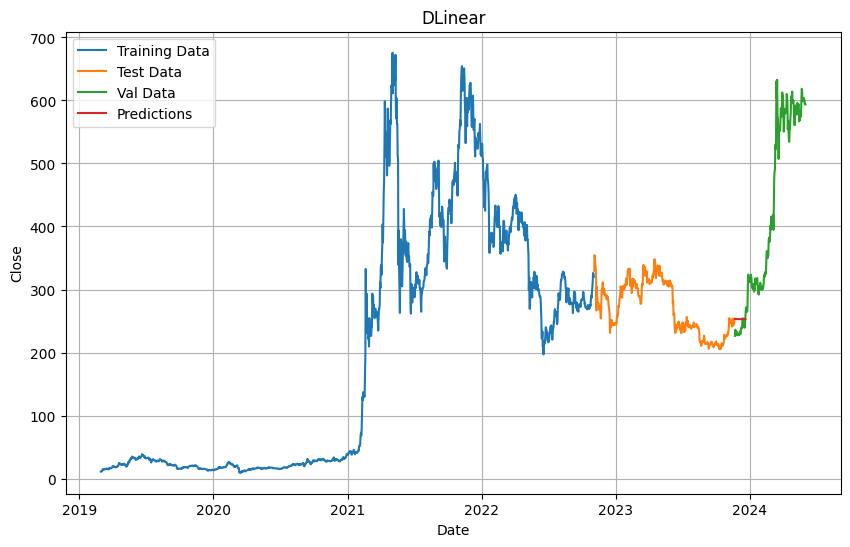

In [30]:
# DL 30 NGÀY
import matplotlib.pyplot as plt
# Chuyển dữ liệu dự báo từ tensor về numpy array
predicted_values = [pred[0].numpy() for pred in predicted]

# Chuyển đổi dữ liệu gốc từ tensor về numpy array
original_values = input_data[0, :, :].numpy()


# #
# last_date = df['Date'].max()
predicted_dates = pd.date_range(start=first_Date_2 + pd.DateOffset(days=1), periods=len(predicted_values))

# Tạo mảng chứa ngày gốc
original_dates = df['Date'].values

# Vẽ biểu đồ
plt.figure(figsize=(10, 6))

plt.plot(train_date_data, train_data, label='Training Data')
plt.plot(test_date_data, test_data, label='Test Data')
plt.plot(val_date_data, val_data, label='Val Data')
plt.plot(predicted_dates, predicted_values, label='Predictions')

plt.xlabel('Date')
plt.ylabel('Close')
plt.title('DLinear')
plt.legend()
plt.grid(True)
plt.show()


In [34]:
# Dự đoán dữ liệu trên tập test dựa vào tập train
import torch.optim as optim

# Xác định hàm mất mát và trình tối ưu hóa
criterion = nn.MSELoss()
optimizer = optim.Adam(model_train.parameters(), lr=0.001)  # Có thể điều chỉnh lr theo yêu cầu

# Huấn luyện mô hình
num_epochs = 100  # Số lượng epoch
for epoch in range(num_epochs):
    model_train.train()  # Chuyển sang chế độ huấn luyện
    optimizer.zero_grad()  # Đặt gradient về 0

    # Feedforward
    outputs = model_train(input_data_train)

    # Tính toán loss
    loss = criterion(outputs, input_data_train)  # So sánh đầu ra với đầu vào

    # Backpropagation
    loss.backward()  # Tính toán gradient
    optimizer.step()  # Cập nhật trọng số

    # In ra loss sau mỗi epoch
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/100], Loss: 0.5408
Epoch [2/100], Loss: 71692.7812
Epoch [3/100], Loss: 4687.2471
Epoch [4/100], Loss: 15196.8789
Epoch [5/100], Loss: 41250.9609
Epoch [6/100], Loss: 31486.3086
Epoch [7/100], Loss: 9245.7031
Epoch [8/100], Loss: 18.9453
Epoch [9/100], Loss: 8376.4062
Epoch [10/100], Loss: 19293.3262
Epoch [11/100], Loss: 19246.7422
Epoch [12/100], Loss: 10049.9150
Epoch [13/100], Loss: 1548.7185
Epoch [14/100], Loss: 674.8947
Epoch [15/100], Loss: 6065.6265
Epoch [16/100], Loss: 10685.2285
Epoch [17/100], Loss: 9734.6719
Epoch [18/100], Loss: 4721.6699
Epoch [19/100], Loss: 567.7556
Epoch [20/100], Loss: 539.2628
Epoch [21/100], Loss: 3572.3069
Epoch [22/100], Loss: 5905.3315
Epoch [23/100], Loss: 5141.0942
Epoch [24/100], Loss: 2292.0173
Epoch [25/100], Loss: 178.6802
Epoch [26/100], Loss: 472.5319
Epoch [27/100], Loss: 2271.7688
Epoch [28/100], Loss: 3356.0376
Epoch [29/100], Loss: 2602.3804
Epoch [30/100], Loss: 921.1010
Epoch [31/100], Loss: 8.7759
Epoch [32/100], Loss: 5

In [32]:
# Dự báo cho 451 ngày kế tiếp
# # Chuyển sang chế độ đánh giá
model_train.eval()

# Không cần tính gradient trong quá trình dự báo
with torch.no_grad():
    input_data_future = input_data_train.clone()  # Tạo một bản sao của dữ liệu đầu vào để cập nhật dự báo
    predicted = []  # Danh sách dự báo cho các ngày tiếp theo
    for i in range(test_size):  # Dự báo cho 30 ngày tiếp theo
        # Dự báo cho ngày hiện tại
        output = model_train(input_data_future)
        # Lưu dự báo của ngày hiện tại
        predicted.append(output[:, -1, :])  # Lấy dự báo cho ngày cuối cùng trong chuỗi thời gian
        # Cập nhật dữ liệu đầu vào cho ngày tiếp theo
        input_data_future = torch.cat([input_data_future[:, :, 1:], output], dim=2)

    # In ra dự báo cho 30 ngày tiếp theo
    print("Predicted Output for the next 451 days:")
    for i in range(test_size):
        # In ra ngày tương ứng với dự báo
        print(f"Day {i+1}: {first_Date + pd.DateOffset(days=i+1)} - Predicted: {predicted[i][0]}")

Predicted Output for the next 451 days:
Day 1: 2022-11-04 00:00:00 - Predicted: tensor([320.4591])
Day 2: 2022-11-05 00:00:00 - Predicted: tensor([320.0960])
Day 3: 2022-11-06 00:00:00 - Predicted: tensor([319.7082])
Day 4: 2022-11-07 00:00:00 - Predicted: tensor([319.3195])
Day 5: 2022-11-08 00:00:00 - Predicted: tensor([318.9312])
Day 6: 2022-11-09 00:00:00 - Predicted: tensor([318.5435])
Day 7: 2022-11-10 00:00:00 - Predicted: tensor([318.1562])
Day 8: 2022-11-11 00:00:00 - Predicted: tensor([317.7694])
Day 9: 2022-11-12 00:00:00 - Predicted: tensor([317.3830])
Day 10: 2022-11-13 00:00:00 - Predicted: tensor([316.9972])
Day 11: 2022-11-14 00:00:00 - Predicted: tensor([316.6117])
Day 12: 2022-11-15 00:00:00 - Predicted: tensor([316.2268])
Day 13: 2022-11-16 00:00:00 - Predicted: tensor([315.8423])
Day 14: 2022-11-17 00:00:00 - Predicted: tensor([315.4583])
Day 15: 2022-11-18 00:00:00 - Predicted: tensor([315.0748])
Day 16: 2022-11-19 00:00:00 - Predicted: tensor([314.6917])
Day 17: 2

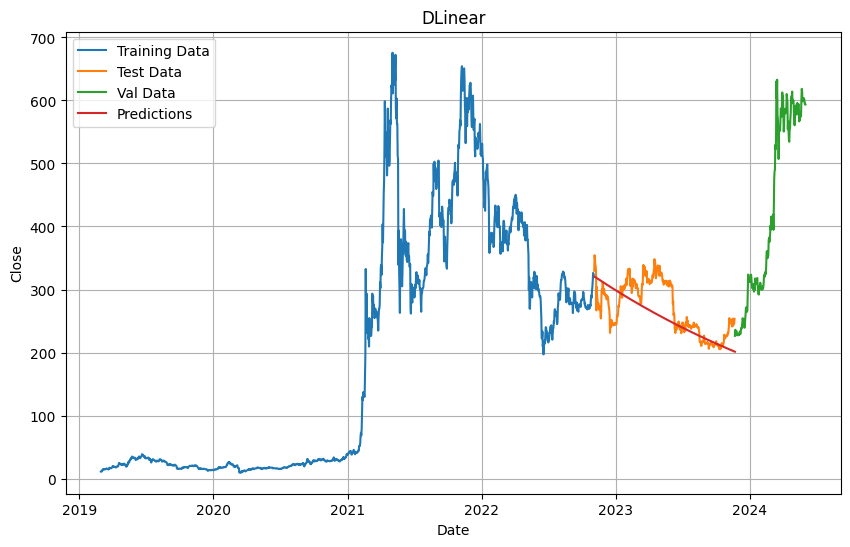

In [33]:
# dl 451 NGÀY
import matplotlib.pyplot as plt
# Chuyển dữ liệu dự báo từ tensor về numpy array
predicted_values = [pred[0].numpy() for pred in predicted]

# Chuyển đổi dữ liệu gốc từ tensor về numpy array
original_values = input_data[0, :, :].numpy()

#
predicted_dates = pd.date_range(start=first_Date + pd.DateOffset(days=1), periods=len(predicted_values))

# Tạo mảng chứa ngày gốc
original_dates = df['Date'].values

# Vẽ biểu đồ
plt.figure(figsize=(10, 6))

plt.plot(train_date_data, train_data, label='Training Data')
plt.plot(test_date_data, test_data, label='Test Data')
plt.plot(val_date_data, val_data, label='Val Data')
plt.plot(predicted_dates, predicted_values, label='Predictions')


plt.xlabel('Date')
plt.ylabel('Close')
plt.title('DLinear')
plt.legend()
plt.grid(True)
plt.show()